In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler

import joblib
torch.manual_seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
train_data=pd.read_csv('./assets/processed dataset/train dataset.csv')
validation_data=pd.read_csv('./assets/processed dataset/validation dataset.csv')
validation_data.head()


,PRECTOT,QV2M,T2M_MAX,T2M_MIN
0,0.0,3.55,22.99,8.58
1,0.0,3.56,23.24,9.58
2,0.0,3.98,22.89,8.34
3,0.0,5.12,22.99,10.75
4,0.0,5.47,24.10,10.47


In [4]:
#Data scaling
scaler=MinMaxScaler()
normalized_train_data=scaler.fit_transform(train_data)
joblib.dump(scaler, "./assets/scaler.gz") 
print(scaler.scale_)
print(normalized_train_data[0])
normalized_validation_data=scaler.transform(validation_data)
print(normalized_validation_data[0])

[0.01221598 0.0656168  0.03913894 0.04288165]
[0.         0.22440945 0.2704501  0.35034305]
[0.         0.17847769 0.7592955  0.64193825]


In [5]:
#Prepearing X and Y for training and validation
# Setting THE SEQUENCE LENGTH 
seq_length=180
#initialized to a empty 1d list
X_train=[]
Y_train=[]
X_validate=[]
Y_validate=[]
for i in range(seq_length,train_data.shape[0]):
    #Data from 0 to 59TH index
    X_train.append(normalized_train_data[i-seq_length:i])
    #T2M AT THE 60TH index
    Y_train.append(normalized_train_data[i])

for i in range(seq_length,validation_data.shape[0]):
    #Data from 0 to 59TH index
    X_validate.append(normalized_validation_data[i-seq_length:i])
    #T2M AT THE 60TH index
    Y_validate.append(normalized_validation_data[i])

# converting into numpy arrays
X_train,Y_train=np.array(X_train),np.array(Y_train)
#change to 2d array from 1d array
Y_train=Y_train.reshape(-1,4)
print(X_train.shape,Y_train.shape)

X_validate,Y_validate=np.array(X_validate),np.array(Y_validate)
Y_validate=Y_validate.reshape(-1,4)
print(X_validate.shape,Y_validate.shape)

X_train = Variable(torch.Tensor(X_train))
Y_train = Variable(torch.Tensor(Y_train))
print(X_train.shape,Y_train.shape)

X_validate = Variable(torch.Tensor(X_validate))
Y_validate = Variable(torch.Tensor(Y_validate))
print(X_validate.shape,Y_validate.shape)

(9789, 180, 4) (9789, 4)
(1956, 180, 4) (1956, 4)
torch.Size([9789, 180, 4]) torch.Size([9789, 4])
torch.Size([1956, 180, 4]) torch.Size([1956, 4])


In [6]:
#BILSTM Network definition
class NETWORK_BILSTM(nn.Module):

    def __init__(self,num_classes,input_size,hidden_size,num_layers):
        super(NETWORK_BILSTM,self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm=nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,bidirectional=True).to(device)
        self.fc=nn.Linear(hidden_size*2,num_classes)
    
    def forward(self,x):
        output_lstm, (h_n,c_n) = self.lstm(x)
        input_fc=output_lstm[:,-1,:]
        output_fc=self.fc(input_fc).to(device)
        return output_fc

In [7]:
#Initializing model with parameters
num_epochs=50
learning_rate=0.01
input_size=4
hidden_size=8
num_layers=1
num_classes=4

model=NETWORK_BILSTM(num_classes,input_size, hidden_size,num_layers)
model.to(device)

NETWORK_BILSTM(
  (lstm): LSTM(4, 8, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

In [8]:
# DEFINE OPTIMIZER
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Lists to store training losses for plotting the training curve
train_losses = []
valid_losses=[]
#batch gradient descent
# TRAIN THE MODEL:
for epoch in range(1,num_epochs+1):
    model.train()
    outputs = model(X_train.to(device))
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, Y_train.to(device))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        valid_outputs=model(X_validate.to(device))
        valid_loss=criterion(valid_outputs,Y_validate.to(device))
        valid_losses.append(valid_loss.item())
    if epoch % 1 == 0:
        print("Epoch: %d, training loss: %1.5f, validation loss: %1.5f" % (epoch, loss.item(),valid_loss.item()))

Epoch: 10, training loss: 0.04776, validation loss: 0.05355
Epoch: 20, training loss: 0.03656, validation loss: 0.03345
Epoch: 30, training loss: 0.02774, validation loss: 0.02568
Epoch: 40, training loss: 0.01838, validation loss: 0.01681
Epoch: 50, training loss: 0.01118, validation loss: 0.00976


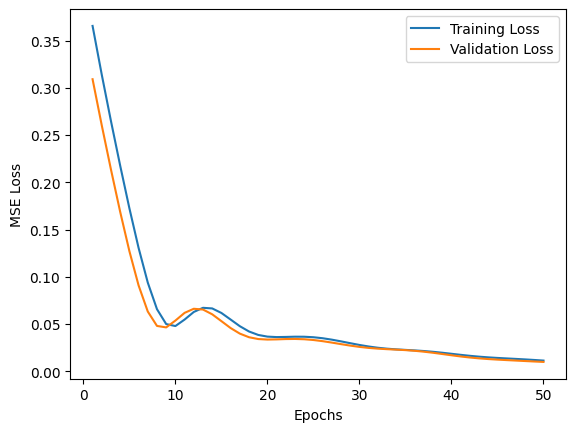

In [9]:
# Plotting the training curve
epochs=range(1,num_epochs+1)
st=0;end=50
plt.plot( epochs[st:end],train_losses[st:end], label='Training Loss')
plt.plot(epochs[st:end],valid_losses[st:end], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [10]:
torch.save(model.state_dict(),'./assets/trained models state/bilstm_state.pt')